In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

cell_df="/home/maria/LuckyMouse2/neuron_property_decoding/data/cell_metrics_joined.csv"
neuron_embeddings="/home/maria/LuckyMouse2/neuron_property_decoding/data/neuron_embeddings.npy"
cell_df=pd.read_csv(cell_df)
neuron_embeddings=np.load(neuron_embeddings)
merged_df=cell_df
X=neuron_embeddings
# Load embeddings (e.g. from your model output)
#X = np.load("/path/to/your_neuron_embeddings.npy")  # shape (N, 64)
merged_df = merged_df.sort_values("data_row_index").reset_index(drop=True)

# Select targets
targets = [
    'osi_dg', 'dsi_dg', 'g_osi_dg', 'g_dsi_dg',
    'reliability_dg', 'reliability_nm1_a',
    'run_mod_dg', 'tfdi_dg', 'pref_tf_dg',
    'peak_dff_dg'
]
Y_df = merged_df[targets]

Y_df_filled = Y_df.fillna(0.0)
Y = Y_df_filled.to_numpy(dtype=np.float32)
class NeuronPropertyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)
        self.mask = ~torch.isnan(self.Y)  # 1 where target exists

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.mask[idx]
    
import torch.nn as nn

class MultiTaskRegressor(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.net(x)
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Split data
train_idx, test_idx = train_test_split(
    np.arange(X.shape[0]), test_size=0.2, random_state=42
)

train_dataset = NeuronPropertyDataset(X[train_idx], Y[train_idx])
test_dataset = NeuronPropertyDataset(X[test_idx], Y[test_idx])
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512)

# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskRegressor(input_dim=X.shape[1], output_dim=Y.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def masked_mse_loss(pred, target, mask):
    diff = pred - target
    loss = (diff**2 * mask).sum() / mask.sum()
    return loss

# Training loop
n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    total_loss = 0
    for x_batch, y_batch, mask_batch in train_loader:
        x_batch, y_batch, mask_batch = x_batch.to(device), y_batch.to(device), mask_batch.to(device)
        preds = model(x_batch)
        loss = masked_mse_loss(preds, y_batch, mask_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{n_epochs} | Loss: {total_loss:.4f}")

model.eval()
with torch.no_grad():
    X_test = torch.tensor(X[test_idx], dtype=torch.float32).to(device)
    Y_test = torch.tensor(Y[test_idx], dtype=torch.float32).to(device)
    mask_test = ~torch.isnan(Y_test)

    preds = model(X_test)
    preds = preds.cpu().numpy()
    Y_test = Y_test.cpu().numpy()
    mask_test = mask_test.cpu().numpy()

# R² for each task
print("\n📈 Variance explained per property:")
for i, name in enumerate(targets):
    mask = mask_test[:, i]
    if mask.sum() == 0:
        print(f"{name}: No data")
        continue
    r2 = r2_score(Y_test[mask, i], preds[mask, i])
    print(f"{name}: R² = {r2:.4f}")



Epoch 1/100 | Loss: 60157.2138
Epoch 2/100 | Loss: 59881.9865
Epoch 3/100 | Loss: 59798.8733
Epoch 4/100 | Loss: 59694.1574
Epoch 5/100 | Loss: 59590.5330
Epoch 6/100 | Loss: 59453.4997
Epoch 7/100 | Loss: 59364.0451
Epoch 8/100 | Loss: 59393.5859
Epoch 9/100 | Loss: 59175.0939
Epoch 10/100 | Loss: 59024.8571
Epoch 11/100 | Loss: 58934.6073
Epoch 12/100 | Loss: 58722.4626
Epoch 13/100 | Loss: 58490.3666
Epoch 14/100 | Loss: 58175.9805
Epoch 15/100 | Loss: 57643.2842
Epoch 16/100 | Loss: 57100.8867
Epoch 17/100 | Loss: 56431.3131
Epoch 18/100 | Loss: 55656.4530
Epoch 19/100 | Loss: 54634.9316
Epoch 20/100 | Loss: 53655.8958
Epoch 21/100 | Loss: 52521.8843
Epoch 22/100 | Loss: 51113.2843
Epoch 23/100 | Loss: 49612.7865
Epoch 24/100 | Loss: 55705.6016
Epoch 25/100 | Loss: 46553.8355
Epoch 26/100 | Loss: 44019.6302
Epoch 27/100 | Loss: 42580.0331
Epoch 28/100 | Loss: 40219.3167
Epoch 29/100 | Loss: 37481.2137
Epoch 30/100 | Loss: 36145.3332
Epoch 31/100 | Loss: 34203.4747
Epoch 32/100 | Lo

In [8]:
print("\n📈 Variance explained per property:")
for i, name in enumerate(targets):
    mask = mask_test[:, i]
    if mask.sum() == 0:
        print(f"{name}: No data")
        continue
    r2 = r2_score(Y_test[mask, i], preds[mask, i])
    print(f"{name}: R² = {r2:.4f}")


📈 Variance explained per property:
osi_dg: R² = -0.5606
dsi_dg: R² = -0.0886
g_osi_dg: R² = -0.3425
g_dsi_dg: R² = -0.2840
reliability_dg: R² = -3.7606
reliability_nm1_a: R² = -1.6857
run_mod_dg: R² = -0.1101
tfdi_dg: R² = -0.4426
pref_tf_dg: R² = -0.0158
peak_dff_dg: R² = -0.8350


Y shape: (39209, 10)


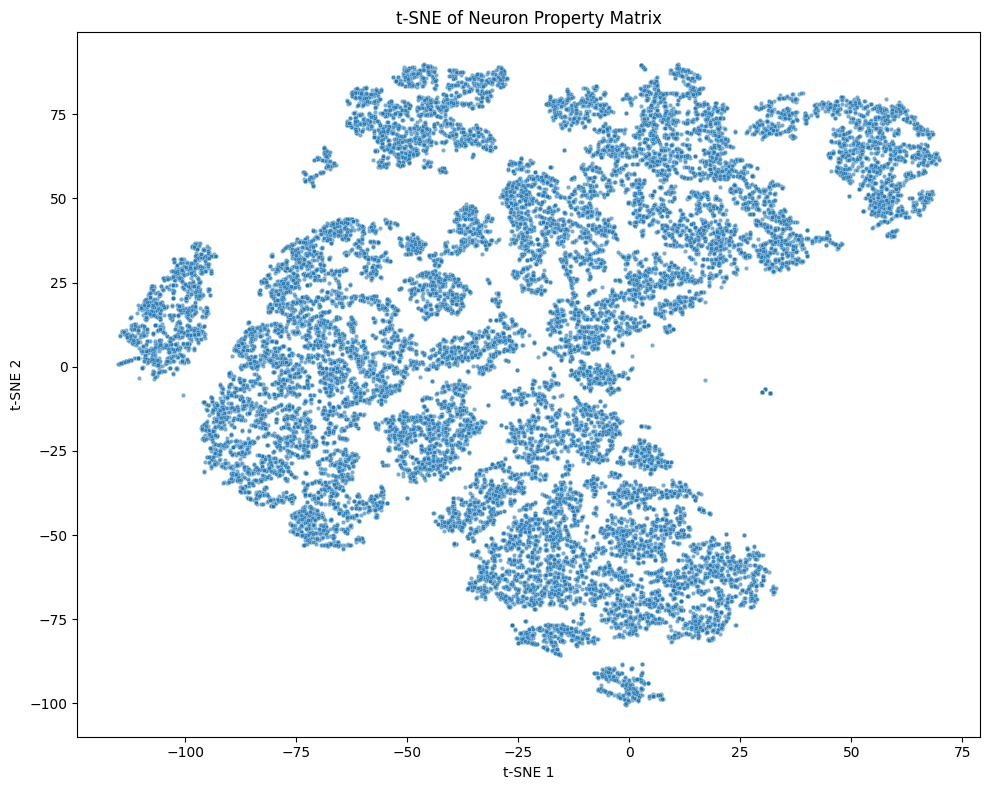

In [10]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Y should already be filled and float32
# Shape: (n_neurons, n_properties)
print("Y shape:", Y.shape)

# Optional: standardize the features before t-SNE
from sklearn.preprocessing import StandardScaler
Y_std = StandardScaler().fit_transform(Y)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
Y_tsne = tsne.fit_transform(Y_std)

# Plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=Y_tsne[:, 0], y=Y_tsne[:, 1], s=10, alpha=0.6)
plt.title("t-SNE of Neuron Property Matrix")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()


/home/maria/global_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/maria/global_venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


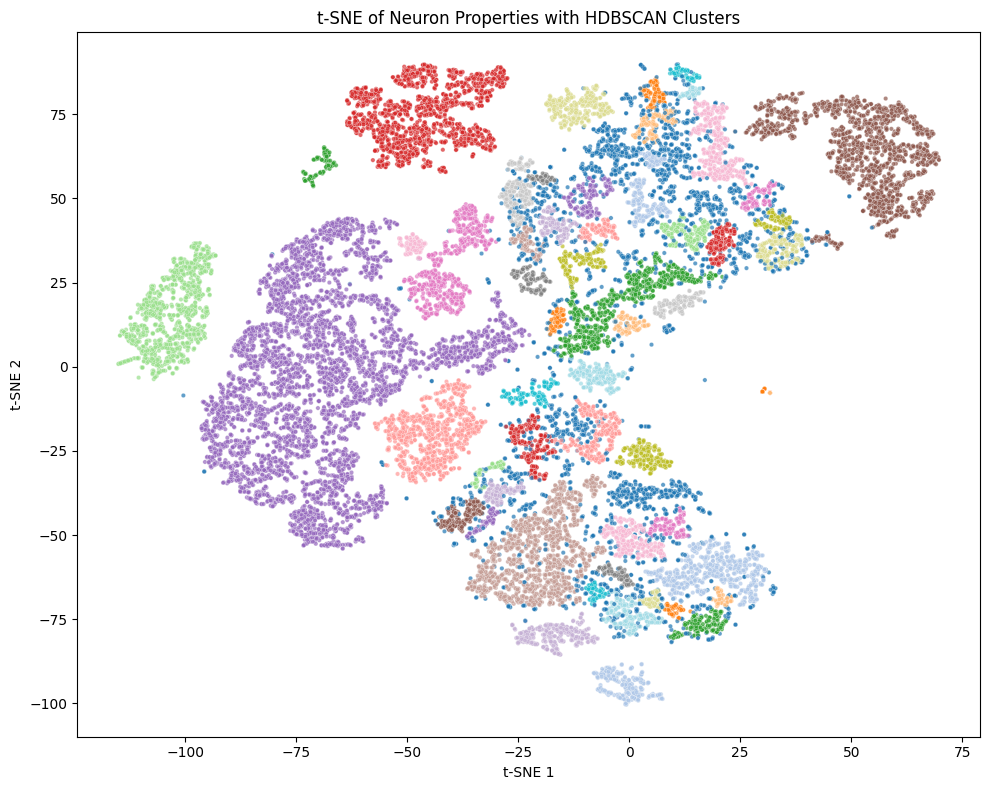

In [15]:
import hdbscan

# Fit HDBSCAN on the 2D t-SNE space
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10)
cluster_labels = clusterer.fit_predict(Y_tsne)

# Add labels to DataFrame
merged_df['cluster'] = cluster_labels

# Visualize
plt.figure(figsize=(10, 8))
sns.scatterplot(x=Y_tsne[:, 0], y=Y_tsne[:, 1], hue=cluster_labels,
                palette='tab20', s=10, alpha=0.7, legend=None)
plt.title("t-SNE of Neuron Properties with HDBSCAN Clusters")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()
